In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using device: cuda
Loading Sentence Transformer model...
Sentence Transformer model loaded successfully

=== Analyzing Hindi dataset ===
Attempting CSV read strategy 1...
Strategy 1 successful: {'quoting': 0}
Dataset statistics for /kaggle/input/capstone/uli_dataset-main/training/train_hi_l1.csv:
Total samples: 6197
Average text length (characters): 79.12
Average word count: 16.70
Max text length: 280
Min text length: 0
Text length distribution saved as 'hindi_text_length_distribution.png'
Reading training data from /kaggle/input/capstone/uli_dataset-main/training/train_hi_l1.csv...
Attempting CSV read strategy 1...
Strategy 1 successful: {'quoting': 0}
Training data loaded successfully with 6197 rows
Preprocessing Hindi training text...
Calculating majority vote for training labels...

Training class distribution:
label_class
0.0    4436
1.0    1760
0.5       1
Name: count, dtype: int64
Class distribution plot saved as 'hindi_training_class_distribution.png'

Creating feature pipeline

Batches:   0%|          | 0/194 [00:00<?, ?it/s]

Model training complete!

Reading test data from /kaggle/input/capstone/uli_dataset-main/testing/test_hi_l1.csv...
Attempting CSV read strategy 1...
Strategy 1 failed: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.

Attempting CSV read strategy 2...
Strategy 2 successful: {'engine': 'python', 'quoting': 0}
Test data loaded successfully with 1517 rows
Preprocessing Hindi test text...
Calculating majority vote for test labels...
Making predictions on test data...


Batches:   0%|          | 0/48 [00:00<?, ?it/s]


Evaluating model performance...

Macro F1 Score: 0.7012

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.87      1159
         1.0       0.56      0.51      0.54       358

    accuracy                           0.79      1517
   macro avg       0.71      0.69      0.70      1517
weighted avg       0.79      0.79      0.79      1517

Confusion matrix saved as 'hindi_confusion_matrix.png'

Saving sample predictions...
Test predictions saved to 'hindi_test_predictions.csv'
Saving model to hindi_classifier_model.joblib...
Model saved successfully to hindi_classifier_model.joblib

=== Testing model on sample texts ===
Error during prediction: 'list' object has no attribute 'tolist'
Error during prediction: 'list' object has no attribute 'tolist'
Error during prediction: 'list' object has no attribute 'tolist'
Error during prediction: 'list' object has no attribute 'tolist'
Error during prediction: 'list' objec

Batches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/48 [00:00<?, ?it/s]

Predictions saved to hindi_new_predictions.csv

Prediction distribution:
0.0    1193
1.0     324
Name: count, dtype: int64


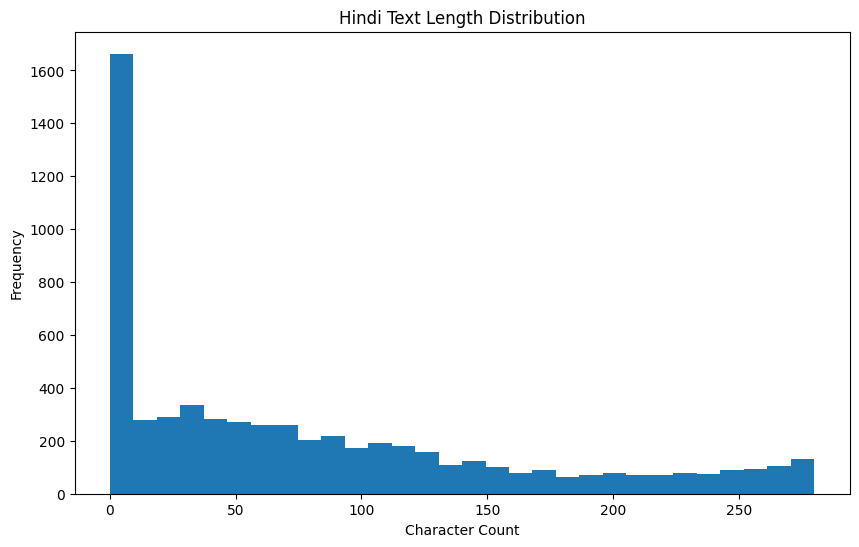

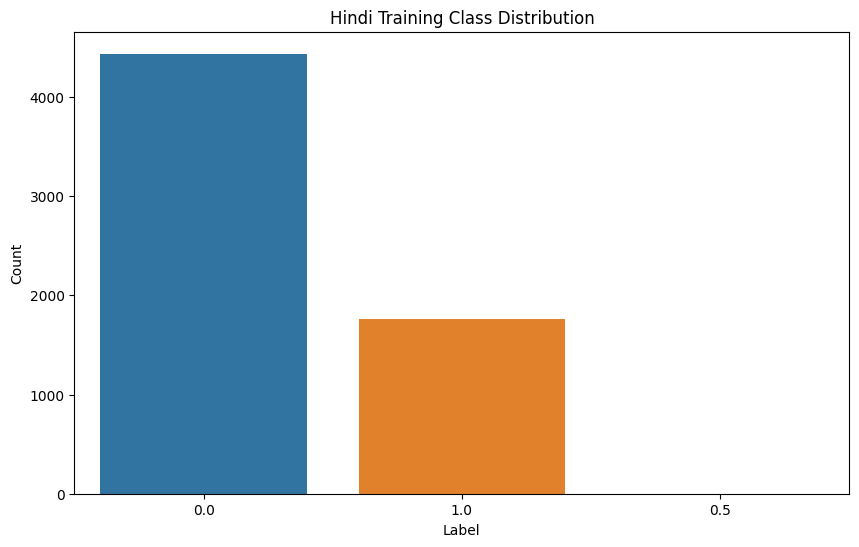

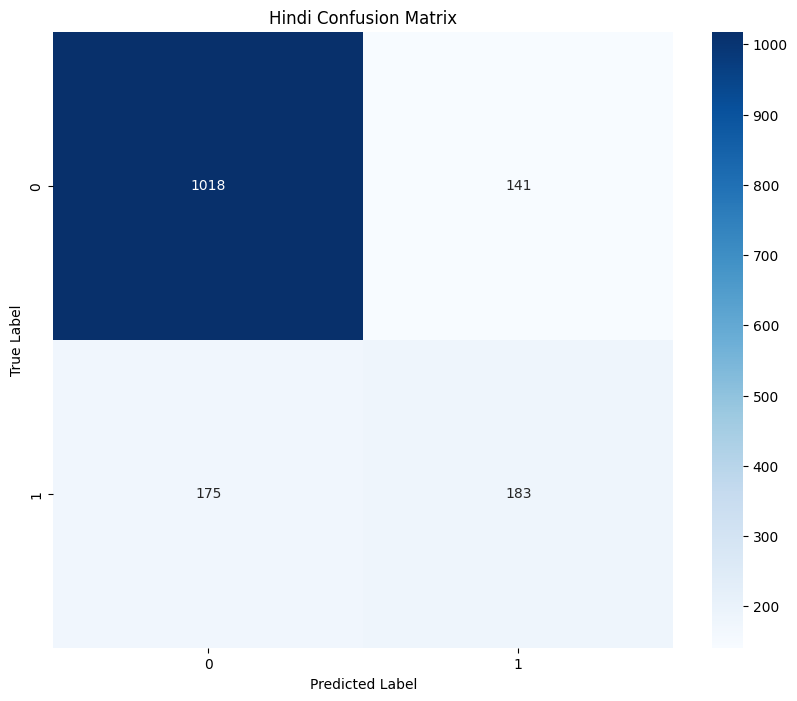

In [6]:
import pandas as pd
import numpy as np
import re
import csv
import os
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import torch
from sentence_transformers import SentenceTransformer

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Function to preprocess Hindi text
def preprocess_hindi_text(text):
    if not isinstance(text, str):
        return ""
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Handle Hindi-specific cleaning (preserve Hindi characters)
    # Hindi Unicode range: \u0900-\u097F
    # Keep Hindi characters, numerals, spaces, and remove others
    text = re.sub(r'[^\u0900-\u097F0-9\s]', '', text)
    
    # Simple tokenization approach for Hindi using whitespace
    text = ' '.join(text.split())
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Safe function to read CSV files with various error handling techniques
def safe_read_csv(file_path):
    """
    Attempts multiple strategies to safely read potentially problematic CSV files.
    
    Args:
        file_path: Path to the CSV file
    
    Returns:
        Pandas DataFrame or None if all strategies fail
    """
    # List of strategies to try
    strategies = [
        # Strategy 1: Default with minimal quoting
        {"quoting": csv.QUOTE_MINIMAL},
        
        # Strategy 2: Use Python engine instead of C engine
        {"engine": "python", "quoting": csv.QUOTE_MINIMAL},
        
        # Strategy 3: Disable quoting 
        {"quoting": csv.QUOTE_NONE, "engine": "python"},
        
        # Strategy 4: Increase field size limit
        {"quoting": csv.QUOTE_MINIMAL, "engine": "python", "on_bad_lines": "skip"},
        
        # Strategy 5: Try with different encoding
        {"encoding": "utf-8", "engine": "python"},
        
        # Strategy 6: Try with latin-1 encoding
        {"encoding": "latin-1", "engine": "python"},
        
        # Strategy 7: Try with explicit delimiter
        {"delimiter": ",", "engine": "python", "on_bad_lines": "skip"},
        
        # Strategy 8: Try with flexible error handling
        {"engine": "python", "on_bad_lines": "warn"},
    ]
    
    # Increase CSV field size limit
    import sys
    max_int = sys.maxsize
    while True:
        try:
            csv.field_size_limit(max_int)
            break
        except OverflowError:
            max_int = int(max_int/10)
    
    # Try each strategy
    for i, params in enumerate(strategies):
        try:
            print(f"Attempting CSV read strategy {i+1}...")
            df = pd.read_csv(file_path, **params)
            print(f"Strategy {i+1} successful: {params}")
            return df
        except Exception as e:
            print(f"Strategy {i+1} failed: {str(e)}")
    
    # If all strategies fail, try a more radical approach: read line by line
    try:
        print("Attempting to read CSV line by line...")
        rows = []
        with open(file_path, 'r', newline='', encoding='utf-8') as file:
            csv_reader = csv.reader(file)
            headers = next(csv_reader)
            for row in csv_reader:
                if len(row) == len(headers):  # Only include rows with correct number of fields
                    rows.append(row)
        
        df = pd.DataFrame(rows, columns=headers)
        print("Line-by-line reading successful")
        return df
    except Exception as e:
        print(f"Line-by-line reading failed: {str(e)}")
    
    # If all approaches fail
    print("All CSV reading strategies failed.")
    return None

# Initialize Sentence Transformer model
# Initialize Sentence Transformer model
print("Loading Sentence Transformer model...")
sentence_model = SentenceTransformer('google/muril-base-cased', device=device)
print(f"Sentence Transformer model loaded successfully")
# Custom transformer for Sentence Transformer embeddings
class SentenceTransformerFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, model=None, batch_size=32):
        """
        Extract Sentence Transformer embeddings for text classification.
        
        Args:
            model: Pre-trained Sentence Transformer model
            batch_size: Batch size for processing
        """
        self.model = model
        self.batch_size = batch_size
    
    def fit(self, X, y=None):
        # Nothing to fit, just initialize
        if self.model is None:
            self.model = sentence_model
        return self
    
    def transform(self, X):
        """Transform texts to sentence embeddings"""
        # Use sentence-transformers' built-in batching
        embeddings = self.model.encode(
            X.tolist(), 
            batch_size=self.batch_size, 
            show_progress_bar=True,
            convert_to_numpy=True
        )
        return embeddings

# Hindi-specific majority vote function
def majority_vote_hindi(row):
    # Extract annotation columns for Hindi dataset
    annotation_cols = ['hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5', 'hi_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_hindi_classifier(train_file, test_file=None):
    """
    Train a Hindi text classifier using SVM with combined Sentence Transformer
    and optimized Hindi text features.
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file with robust parsing
        print(f"Reading training data from {train_file}...")
        train_df = safe_read_csv(train_file)
        
        if train_df is None:
            print("Failed to read training data. Aborting.")
            return None, None, None
        
        # Check required columns
        required_cols = ['text']
        missing_cols = [col for col in required_cols if col not in train_df.columns]
        if missing_cols:
            print(f"Error: Missing required columns: {missing_cols}")
            print(f"Available columns: {train_df.columns.tolist()}")
            return None, None, None
        
        print(f"Training data loaded successfully with {len(train_df)} rows")
        
        # Preprocess text column
        print("Preprocessing Hindi training text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_hindi_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote_hindi, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the class distribution
        print("\nTraining class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Hindi Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('hindi_training_class_distribution.png')
        print("Class distribution plot saved as 'hindi_training_class_distribution.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        # Create pipeline with combined feature extractors optimized for Hindi
        print("\nCreating feature pipeline with Sentence Transformer embeddings, Hindi-optimized features, and SVM classifier...")
        
        # Feature union pipeline combining Sentence Transformers and optimized Hindi features
        feature_union = FeatureUnion([
            ('sentence_embeddings', Pipeline([
                ('sentence_transformer', SentenceTransformerFeatures(
                    model=sentence_model,
                    batch_size=32
                )),
                ('scaler_sbert', StandardScaler())
            ])),
            ('hindi_features', Pipeline([
                ('vectorizer', CountVectorizer(
                    max_features=15000,     # More features for Hindi's morphological complexity
                    ngram_range=(1, 3),     # Unigrams, bigrams and trigrams for Hindi
                    min_df=3,
                    max_df=0.9,
                    analyzer='char_wb',     # Character n-grams with word boundaries, better for Hindi
                )),
                ('tfidf', TfidfTransformer())
            ]))
        ])
        
        # Full pipeline with combined features and SVM
        pipeline = Pipeline([
            ('features', feature_union),
            ('classifier', SVC(
                C=5.0,                  # Less regularization for Hindi's feature richness 
                kernel='rbf',           # Radial basis function kernel
                gamma='scale',          # Scale gamma based on feature variance
                class_weight='balanced', # Handle class imbalance
                probability=True,       # Enable probability estimates
                random_state=42
            ))
        ])
        
        # Train the model
        print("Training the model (extracting combined features and fitting SVM)...")
        pipeline.fit(X_train, y_train)
        print("Model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            print(f"\nReading test data from {test_file}...")
            test_df = safe_read_csv(test_file)
            
            if test_df is None:
                print("Failed to read test data. Skipping evaluation.")
                return pipeline, None, None
            
            # Check required columns in test data
            missing_cols = [col for col in required_cols if col not in test_df.columns]
            if missing_cols:
                print(f"Error: Missing required columns in test data: {missing_cols}")
                print(f"Available columns: {test_df.columns.tolist()}")
                return pipeline, None, None
                
            print(f"Test data loaded successfully with {len(test_df)} rows")
            
            # Preprocess test text
            print("Preprocessing Hindi test text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_hindi_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote_hindi, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Hindi Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('hindi_confusion_matrix.png')
            print("Confusion matrix saved as 'hindi_confusion_matrix.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('hindi_test_predictions.csv', index=False)
            print("Test predictions saved to 'hindi_test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new Hindi data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = safe_read_csv(input_file)
        
        if df is None:
            print("Failed to read input data. Aborting.")
            return None
            
        # Check if 'text' column exists
        if 'text' not in df.columns:
            print(f"Error: 'text' column not found in input file.")
            print(f"Available columns: {df.columns.tolist()}")
            return None
        
        # Preprocess text column
        print("Preprocessing Hindi text...")
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get probability estimates
        probabilities = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence
        df['prediction_confidence'] = np.max(probabilities, axis=1)
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Add function to get cleaned Hindi text statistics
def analyze_hindi_dataset(file_path):
    """
    Analyze Hindi dataset characteristics after preprocessing
    
    Args:
        file_path: Path to the CSV file
    """
    try:
        # Read the CSV file
        df = safe_read_csv(file_path)
        
        if df is None:
            print("Failed to read data for analysis. Aborting.")
            return None
            
        # Check if 'text' column exists
        if 'text' not in df.columns:
            print(f"Error: 'text' column not found for analysis.")
            print(f"Available columns: {df.columns.tolist()}")
            return None
        
        # Preprocess text
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Get statistics
        text_lengths = df['processed_text'].str.len()
        word_counts = df['processed_text'].str.split().str.len()
        
        print(f"Dataset statistics for {file_path}:")
        print(f"Total samples: {len(df)}")
        print(f"Average text length (characters): {text_lengths.mean():.2f}")
        print(f"Average word count: {word_counts.mean():.2f}")
        print(f"Max text length: {text_lengths.max()}")
        print(f"Min text length: {text_lengths.min()}")
        
        # Plot text length distribution
        plt.figure(figsize=(10, 6))
        plt.hist(text_lengths, bins=30)
        plt.title('Hindi Text Length Distribution')
        plt.xlabel('Character Count')
        plt.ylabel('Frequency')
        plt.savefig('hindi_text_length_distribution.png')
        print("Text length distribution saved as 'hindi_text_length_distribution.png'")
        
        return df
    
    except Exception as e:
        print(f"Error: {e}")
        return None

# Add these imports at the top of your script
import joblib
import pickle

# Function to save the trained model
def save_model(model, file_path="hindi_classifier_model.joblib"):
    """
    Save the trained model to disk
    
    Args:
        model: Trained classifier model
        file_path: Path where to save the model
    """
    try:
        print(f"Saving model to {file_path}...")
        joblib.dump(model, file_path)
        print(f"Model saved successfully to {file_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

# Function to load the saved model
def load_model(file_path="hindi_classifier_model.joblib"):
    """
    Load a saved model from disk
    
    Args:
        file_path: Path to the saved model
        
    Returns:
        Loaded model or None if loading fails
    """
    try:
        print(f"Loading model from {file_path}...")
        model = joblib.load(file_path)
        print("Model loaded successfully")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Function to perform inference on a single text input
def predict_text(model, text):
    """
    Make a prediction on a single Hindi text input
    
    Args:
        model: Trained classifier model
        text: Text string to classify
        
    Returns:
        Dictionary with prediction results
    """
    try:
        # Preprocess the text
        processed_text = preprocess_hindi_text(text)
        
        # Make prediction
        prediction_class = model.predict([processed_text])[0]
        
        # Get probability estimates
        probabilities = model.predict_proba([processed_text])[0]
        confidence = max(probabilities)
        
        # Convert string prediction back to float value
        prediction_value = float(prediction_class)
        
        result = {
            'original_text': text,
            'processed_text': processed_text,
            'predicted_label_class': prediction_class,
            'predicted_label_value': prediction_value,
            'confidence': confidence
        }
        
        return result
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

# Function to test the model on sample texts
def test_sample_texts(model, samples=None):
    """
    Test the model on a set of sample Hindi texts
    
    Args:
        model: Trained classifier model
        samples: List of texts to test (if None, uses default samples)
        
    Returns:
        DataFrame with prediction results
    """
    if samples is None:
        # Default sample texts - replace with actual Hindi text samples
        samples = [
            "मैं आज बहुत खुश हूँ",  # I am very happy today
            "यह फिल्म बहुत बुरी थी",  # This movie was very bad
            "उसने मुझे धोखा दिया",  # He cheated me
            "हम सभी के लिए एक अच्छा दिन है",  # It's a good day for all of us
            "इस खाने का स्वाद बहुत अच्छा है"  # This food tastes very good
        ]
    
    results = []
    for text in samples:
        result = predict_text(model, text)
        if result:
            results.append(result)
    
    # Create DataFrame from results
    if results:
        df = pd.DataFrame(results)
        print("\nSample prediction results:")
        print(df[['original_text', 'predicted_label_value', 'confidence']])
        return df
    else:
        print("No valid predictions were made.")
        return None


# Add this at the end of your main block
if __name__ == "__main__":
    train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_hi_l1.csv"  # Hindi training file
    test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_hi_l1.csv"     # Hindi test file
    
    # Optional: Analyze dataset characteristics
    print("\n=== Analyzing Hindi dataset ===")
    analyze_hindi_dataset(train_file)
    
    # Train the model and evaluate on test data
    model, macro_f1, report = train_hindi_classifier(train_file, test_file)
    
    # Save the trained model
    if model is not None:
        save_model(model, "hindi_classifier_model.joblib")
        
        # Test the model on sample texts
        print("\n=== Testing model on sample texts ===")
        test_sample_texts(model)
        
        # Example of loading the saved model and using it
        print("\n=== Loading saved model and performing inference ===")
        loaded_model = load_model("hindi_classifier_model_l1.joblib")
        if loaded_model is not None:
            # Create your own sample text list for testing
            my_samples = [
                "मुझे यह पुस्तक पसंद आई",  # I liked this book
                "राजनीति पर चर्चा करना मुश्किल है",  # Discussing politics is difficult
                "क्या आपने आज का समाचार देखा?"  # Did you see today's news?
            ]
            test_sample_texts(loaded_model, my_samples)
        
        # For completeness, show how to use the model on new data
        print("\n=== Using model on new data ===")
        new_data_file = test_file  # Using test file as an example
        output_file = "hindi_new_predictions.csv"
        predict_on_new_data(model, new_data_file, output_file)

Using device: cuda
Loading Sentence Transformer model...
Sentence Transformer model loaded successfully

=== Analyzing Hindi dataset ===
Attempting CSV read strategy 1...
Strategy 1 successful: {'quoting': 0}
Dataset statistics for /kaggle/input/capstone/uli_dataset-main/training/train_hi_l2.csv:
Total samples: 6191
Average text length (characters): 79.18
Average word count: 16.71
Max text length: 280
Min text length: 0
Text length distribution saved as 'hindi_text_length_distribution.png'
Reading training data from /kaggle/input/capstone/uli_dataset-main/training/train_hi_l2.csv...
Attempting CSV read strategy 1...
Strategy 1 successful: {'quoting': 0}
Training data loaded successfully with 6191 rows
Preprocessing Hindi training text...
Calculating majority vote for training labels...

Training class distribution:
label_class
0.0    3147
1.0    3044
Name: count, dtype: int64
Class distribution plot saved as 'hindi_training_class_distribution.png'

Creating feature pipeline with Senten

Batches:   0%|          | 0/194 [00:00<?, ?it/s]

Model training complete!

Reading test data from /kaggle/input/capstone/uli_dataset-main/testing/test_hi_l2.csv...
Attempting CSV read strategy 1...
Strategy 1 failed: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.

Attempting CSV read strategy 2...
Strategy 2 successful: {'engine': 'python', 'quoting': 0}
Test data loaded successfully with 1517 rows
Preprocessing Hindi test text...
Calculating majority vote for test labels...
Making predictions on test data...


Batches:   0%|          | 0/48 [00:00<?, ?it/s]


Evaluating model performance...

Macro F1 Score: 0.6985

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.79      0.71       698
         1.0       0.78      0.62      0.69       819

    accuracy                           0.70      1517
   macro avg       0.71      0.71      0.70      1517
weighted avg       0.71      0.70      0.70      1517

Confusion matrix saved as 'hindi_confusion_matrix.png'

Saving sample predictions...
Test predictions saved to 'hindi_test_predictions.csv'
Saving model to hindi_classifier_model.joblib...
Model saved successfully to hindi_classifier_model.joblib

=== Testing model on sample texts ===
Error during prediction: 'list' object has no attribute 'tolist'
Error during prediction: 'list' object has no attribute 'tolist'
Error during prediction: 'list' object has no attribute 'tolist'
Error during prediction: 'list' object has no attribute 'tolist'
Error during prediction: 'list' objec

Batches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/48 [00:00<?, ?it/s]

Predictions saved to hindi_new_predictions.csv

Prediction distribution:
0.0    859
1.0    658
Name: count, dtype: int64


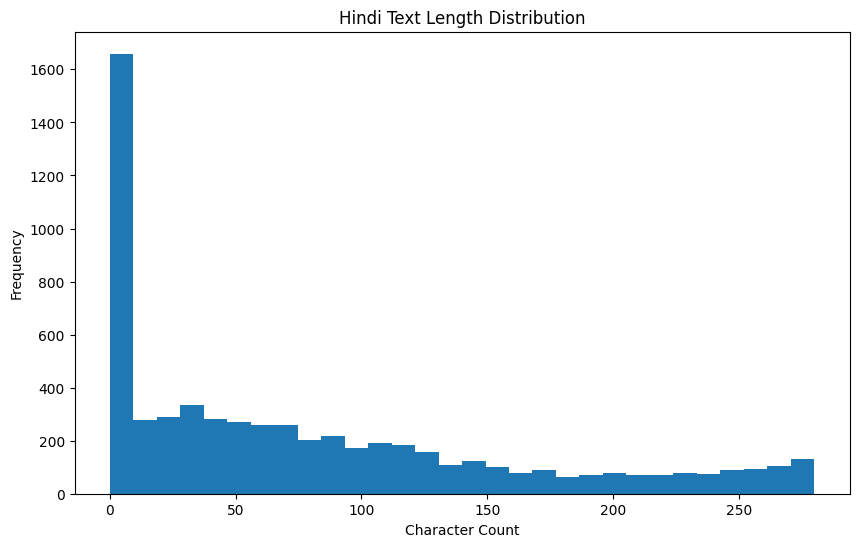

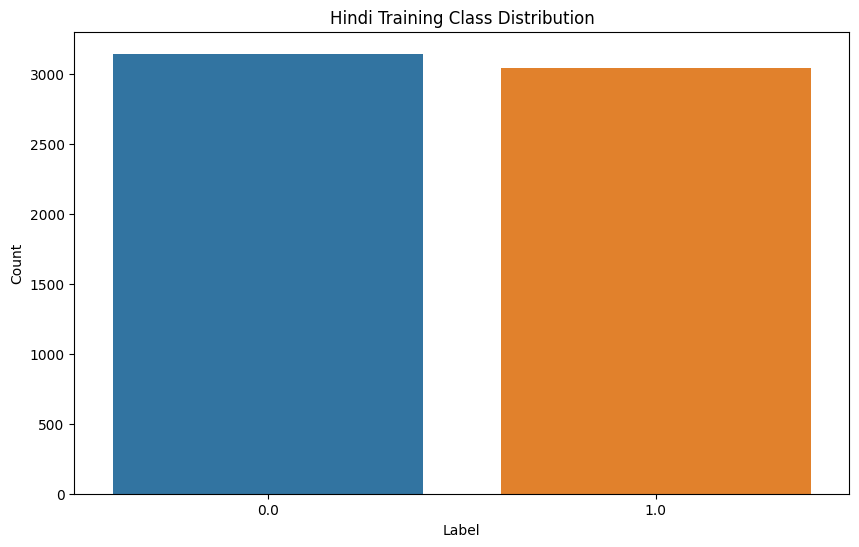

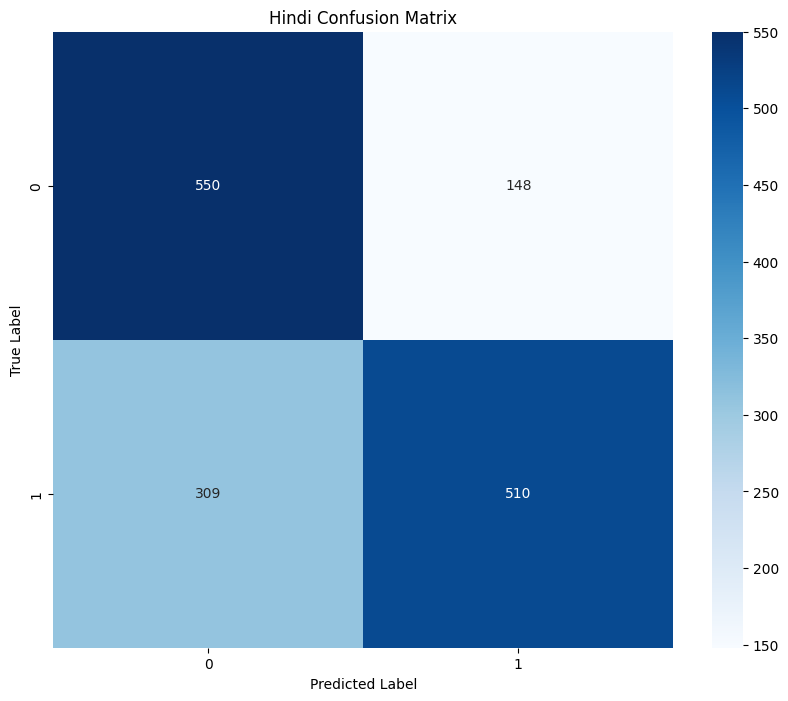

In [7]:
import pandas as pd
import numpy as np
import re
import csv
import os
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import torch
from sentence_transformers import SentenceTransformer

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Function to preprocess Hindi text
def preprocess_hindi_text(text):
    if not isinstance(text, str):
        return ""
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Handle Hindi-specific cleaning (preserve Hindi characters)
    # Hindi Unicode range: \u0900-\u097F
    # Keep Hindi characters, numerals, spaces, and remove others
    text = re.sub(r'[^\u0900-\u097F0-9\s]', '', text)
    
    # Simple tokenization approach for Hindi using whitespace
    text = ' '.join(text.split())
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Safe function to read CSV files with various error handling techniques
def safe_read_csv(file_path):
    """
    Attempts multiple strategies to safely read potentially problematic CSV files.
    
    Args:
        file_path: Path to the CSV file
    
    Returns:
        Pandas DataFrame or None if all strategies fail
    """
    # List of strategies to try
    strategies = [
        # Strategy 1: Default with minimal quoting
        {"quoting": csv.QUOTE_MINIMAL},
        
        # Strategy 2: Use Python engine instead of C engine
        {"engine": "python", "quoting": csv.QUOTE_MINIMAL},
        
        # Strategy 3: Disable quoting 
        {"quoting": csv.QUOTE_NONE, "engine": "python"},
        
        # Strategy 4: Increase field size limit
        {"quoting": csv.QUOTE_MINIMAL, "engine": "python", "on_bad_lines": "skip"},
        
        # Strategy 5: Try with different encoding
        {"encoding": "utf-8", "engine": "python"},
        
        # Strategy 6: Try with latin-1 encoding
        {"encoding": "latin-1", "engine": "python"},
        
        # Strategy 7: Try with explicit delimiter
        {"delimiter": ",", "engine": "python", "on_bad_lines": "skip"},
        
        # Strategy 8: Try with flexible error handling
        {"engine": "python", "on_bad_lines": "warn"},
    ]
    
    # Increase CSV field size limit
    import sys
    max_int = sys.maxsize
    while True:
        try:
            csv.field_size_limit(max_int)
            break
        except OverflowError:
            max_int = int(max_int/10)
    
    # Try each strategy
    for i, params in enumerate(strategies):
        try:
            print(f"Attempting CSV read strategy {i+1}...")
            df = pd.read_csv(file_path, **params)
            print(f"Strategy {i+1} successful: {params}")
            return df
        except Exception as e:
            print(f"Strategy {i+1} failed: {str(e)}")
    
    # If all strategies fail, try a more radical approach: read line by line
    try:
        print("Attempting to read CSV line by line...")
        rows = []
        with open(file_path, 'r', newline='', encoding='utf-8') as file:
            csv_reader = csv.reader(file)
            headers = next(csv_reader)
            for row in csv_reader:
                if len(row) == len(headers):  # Only include rows with correct number of fields
                    rows.append(row)
        
        df = pd.DataFrame(rows, columns=headers)
        print("Line-by-line reading successful")
        return df
    except Exception as e:
        print(f"Line-by-line reading failed: {str(e)}")
    
    # If all approaches fail
    print("All CSV reading strategies failed.")
    return None

# Initialize Sentence Transformer model
# Initialize Sentence Transformer model
print("Loading Sentence Transformer model...")
sentence_model = SentenceTransformer('google/muril-base-cased', device=device)
print(f"Sentence Transformer model loaded successfully")
# Custom transformer for Sentence Transformer embeddings
class SentenceTransformerFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, model=None, batch_size=32):
        """
        Extract Sentence Transformer embeddings for text classification.
        
        Args:
            model: Pre-trained Sentence Transformer model
            batch_size: Batch size for processing
        """
        self.model = model
        self.batch_size = batch_size
    
    def fit(self, X, y=None):
        # Nothing to fit, just initialize
        if self.model is None:
            self.model = sentence_model
        return self
    
    def transform(self, X):
        """Transform texts to sentence embeddings"""
        # Use sentence-transformers' built-in batching
        embeddings = self.model.encode(
            X.tolist(), 
            batch_size=self.batch_size, 
            show_progress_bar=True,
            convert_to_numpy=True
        )
        return embeddings

# Hindi-specific majority vote function
def majority_vote_hindi(row):
    # Extract annotation columns for Hindi dataset
    annotation_cols = ['hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5', 'hi_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_hindi_classifier(train_file, test_file=None):
    """
    Train a Hindi text classifier using SVM with combined Sentence Transformer
    and optimized Hindi text features.
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file with robust parsing
        print(f"Reading training data from {train_file}...")
        train_df = safe_read_csv(train_file)
        
        if train_df is None:
            print("Failed to read training data. Aborting.")
            return None, None, None
        
        # Check required columns
        required_cols = ['text']
        missing_cols = [col for col in required_cols if col not in train_df.columns]
        if missing_cols:
            print(f"Error: Missing required columns: {missing_cols}")
            print(f"Available columns: {train_df.columns.tolist()}")
            return None, None, None
        
        print(f"Training data loaded successfully with {len(train_df)} rows")
        
        # Preprocess text column
        print("Preprocessing Hindi training text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_hindi_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote_hindi, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the class distribution
        print("\nTraining class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Hindi Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('hindi_training_class_distribution.png')
        print("Class distribution plot saved as 'hindi_training_class_distribution.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        # Create pipeline with combined feature extractors optimized for Hindi
        print("\nCreating feature pipeline with Sentence Transformer embeddings, Hindi-optimized features, and SVM classifier...")
        
        # Feature union pipeline combining Sentence Transformers and optimized Hindi features
        feature_union = FeatureUnion([
            ('sentence_embeddings', Pipeline([
                ('sentence_transformer', SentenceTransformerFeatures(
                    model=sentence_model,
                    batch_size=32
                )),
                ('scaler_sbert', StandardScaler())
            ])),
            ('hindi_features', Pipeline([
                ('vectorizer', CountVectorizer(
                    max_features=15000,     # More features for Hindi's morphological complexity
                    ngram_range=(1, 3),     # Unigrams, bigrams and trigrams for Hindi
                    min_df=3,
                    max_df=0.9,
                    analyzer='char_wb',     # Character n-grams with word boundaries, better for Hindi
                )),
                ('tfidf', TfidfTransformer())
            ]))
        ])
        
        # Full pipeline with combined features and SVM
        pipeline = Pipeline([
            ('features', feature_union),
            ('classifier', SVC(
                C=5.0,                  # Less regularization for Hindi's feature richness 
                kernel='rbf',           # Radial basis function kernel
                gamma='scale',          # Scale gamma based on feature variance
                class_weight='balanced', # Handle class imbalance
                probability=True,       # Enable probability estimates
                random_state=42
            ))
        ])
        
        # Train the model
        print("Training the model (extracting combined features and fitting SVM)...")
        pipeline.fit(X_train, y_train)
        print("Model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            print(f"\nReading test data from {test_file}...")
            test_df = safe_read_csv(test_file)
            
            if test_df is None:
                print("Failed to read test data. Skipping evaluation.")
                return pipeline, None, None
            
            # Check required columns in test data
            missing_cols = [col for col in required_cols if col not in test_df.columns]
            if missing_cols:
                print(f"Error: Missing required columns in test data: {missing_cols}")
                print(f"Available columns: {test_df.columns.tolist()}")
                return pipeline, None, None
                
            print(f"Test data loaded successfully with {len(test_df)} rows")
            
            # Preprocess test text
            print("Preprocessing Hindi test text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_hindi_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote_hindi, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Hindi Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('hindi_confusion_matrix.png')
            print("Confusion matrix saved as 'hindi_confusion_matrix.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('hindi_test_predictions.csv', index=False)
            print("Test predictions saved to 'hindi_test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new Hindi data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = safe_read_csv(input_file)
        
        if df is None:
            print("Failed to read input data. Aborting.")
            return None
            
        # Check if 'text' column exists
        if 'text' not in df.columns:
            print(f"Error: 'text' column not found in input file.")
            print(f"Available columns: {df.columns.tolist()}")
            return None
        
        # Preprocess text column
        print("Preprocessing Hindi text...")
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get probability estimates
        probabilities = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence
        df['prediction_confidence'] = np.max(probabilities, axis=1)
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Add function to get cleaned Hindi text statistics
def analyze_hindi_dataset(file_path):
    """
    Analyze Hindi dataset characteristics after preprocessing
    
    Args:
        file_path: Path to the CSV file
    """
    try:
        # Read the CSV file
        df = safe_read_csv(file_path)
        
        if df is None:
            print("Failed to read data for analysis. Aborting.")
            return None
            
        # Check if 'text' column exists
        if 'text' not in df.columns:
            print(f"Error: 'text' column not found for analysis.")
            print(f"Available columns: {df.columns.tolist()}")
            return None
        
        # Preprocess text
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Get statistics
        text_lengths = df['processed_text'].str.len()
        word_counts = df['processed_text'].str.split().str.len()
        
        print(f"Dataset statistics for {file_path}:")
        print(f"Total samples: {len(df)}")
        print(f"Average text length (characters): {text_lengths.mean():.2f}")
        print(f"Average word count: {word_counts.mean():.2f}")
        print(f"Max text length: {text_lengths.max()}")
        print(f"Min text length: {text_lengths.min()}")
        
        # Plot text length distribution
        plt.figure(figsize=(10, 6))
        plt.hist(text_lengths, bins=30)
        plt.title('Hindi Text Length Distribution')
        plt.xlabel('Character Count')
        plt.ylabel('Frequency')
        plt.savefig('hindi_text_length_distribution.png')
        print("Text length distribution saved as 'hindi_text_length_distribution.png'")
        
        return df
    
    except Exception as e:
        print(f"Error: {e}")
        return None

# Add these imports at the top of your script
import joblib
import pickle

# Function to save the trained model
def save_model(model, file_path="hindi_classifier_model.joblib"):
    """
    Save the trained model to disk
    
    Args:
        model: Trained classifier model
        file_path: Path where to save the model
    """
    try:
        print(f"Saving model to {file_path}...")
        joblib.dump(model, file_path)
        print(f"Model saved successfully to {file_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

# Function to load the saved model
def load_model(file_path="hindi_classifier_model.joblib"):
    """
    Load a saved model from disk
    
    Args:
        file_path: Path to the saved model
        
    Returns:
        Loaded model or None if loading fails
    """
    try:
        print(f"Loading model from {file_path}...")
        model = joblib.load(file_path)
        print("Model loaded successfully")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Function to perform inference on a single text input
def predict_text(model, text):
    """
    Make a prediction on a single Hindi text input
    
    Args:
        model: Trained classifier model
        text: Text string to classify
        
    Returns:
        Dictionary with prediction results
    """
    try:
        # Preprocess the text
        processed_text = preprocess_hindi_text(text)
        
        # Make prediction
        prediction_class = model.predict([processed_text])[0]
        
        # Get probability estimates
        probabilities = model.predict_proba([processed_text])[0]
        confidence = max(probabilities)
        
        # Convert string prediction back to float value
        prediction_value = float(prediction_class)
        
        result = {
            'original_text': text,
            'processed_text': processed_text,
            'predicted_label_class': prediction_class,
            'predicted_label_value': prediction_value,
            'confidence': confidence
        }
        
        return result
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

# Function to test the model on sample texts
def test_sample_texts(model, samples=None):
    """
    Test the model on a set of sample Hindi texts
    
    Args:
        model: Trained classifier model
        samples: List of texts to test (if None, uses default samples)
        
    Returns:
        DataFrame with prediction results
    """
    if samples is None:
        # Default sample texts - replace with actual Hindi text samples
        samples = [
            "मैं आज बहुत खुश हूँ",  # I am very happy today
            "यह फिल्म बहुत बुरी थी",  # This movie was very bad
            "उसने मुझे धोखा दिया",  # He cheated me
            "हम सभी के लिए एक अच्छा दिन है",  # It's a good day for all of us
            "इस खाने का स्वाद बहुत अच्छा है"  # This food tastes very good
        ]
    
    results = []
    for text in samples:
        result = predict_text(model, text)
        if result:
            results.append(result)
    
    # Create DataFrame from results
    if results:
        df = pd.DataFrame(results)
        print("\nSample prediction results:")
        print(df[['original_text', 'predicted_label_value', 'confidence']])
        return df
    else:
        print("No valid predictions were made.")
        return None


# Add this at the end of your main block
if __name__ == "__main__":
    train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_hi_l2.csv"  # Hindi training file
    test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_hi_l2.csv"     # Hindi test file
    
    # Optional: Analyze dataset characteristics
    print("\n=== Analyzing Hindi dataset ===")
    analyze_hindi_dataset(train_file)
    
    # Train the model and evaluate on test data
    model, macro_f1, report = train_hindi_classifier(train_file, test_file)
    
    # Save the trained model
    if model is not None:
        save_model(model, "hindi_classifier_model.joblib")
        
        # Test the model on sample texts
        print("\n=== Testing model on sample texts ===")
        test_sample_texts(model)
        
        # Example of loading the saved model and using it
        print("\n=== Loading saved model and performing inference ===")
        loaded_model = load_model("hindi_classifier_model_l2.joblib")
        if loaded_model is not None:
            # Create your own sample text list for testing
            my_samples = [
                "मुझे यह पुस्तक पसंद आई",  # I liked this book
                "राजनीति पर चर्चा करना मुश्किल है",  # Discussing politics is difficult
                "क्या आपने आज का समाचार देखा?"  # Did you see today's news?
            ]
            test_sample_texts(loaded_model, my_samples)
        
        # For completeness, show how to use the model on new data
        print("\n=== Using model on new data ===")
        new_data_file = test_file  # Using test file as an example
        output_file = "hindi_new_predictions.csv"
        predict_on_new_data(model, new_data_file, output_file)

Using device: cuda
Loading Sentence Transformer model...
Sentence Transformer model loaded successfully

=== Analyzing Hindi dataset ===
Attempting CSV read strategy 1...
Strategy 1 successful: {'quoting': 0}
Dataset statistics for /kaggle/input/capstone/uli_dataset-main/training/train_hi_l3.csv:
Total samples: 6197
Average text length (characters): 79.13
Average word count: 16.70
Max text length: 280
Min text length: 0
Text length distribution saved as 'hindi_text_length_distribution.png'
Reading training data from /kaggle/input/capstone/uli_dataset-main/training/train_hi_l3.csv...
Attempting CSV read strategy 1...
Strategy 1 successful: {'quoting': 0}
Training data loaded successfully with 6197 rows
Preprocessing Hindi training text...
Calculating majority vote for training labels...

Training class distribution:
label_class
0.0    3331
1.0    2866
Name: count, dtype: int64
Class distribution plot saved as 'hindi_training_class_distribution.png'

Creating feature pipeline with Senten

Batches:   0%|          | 0/194 [00:00<?, ?it/s]

Model training complete!

Reading test data from /kaggle/input/capstone/uli_dataset-main/testing/test_hi_l3.csv...
Attempting CSV read strategy 1...
Strategy 1 failed: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.

Attempting CSV read strategy 2...
Strategy 2 successful: {'engine': 'python', 'quoting': 0}
Test data loaded successfully with 1517 rows
Preprocessing Hindi test text...
Calculating majority vote for test labels...
Making predictions on test data...


Batches:   0%|          | 0/48 [00:00<?, ?it/s]


Evaluating model performance...

Macro F1 Score: 0.7747

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.86      0.80       767
         1.0       0.83      0.69      0.75       750

    accuracy                           0.78      1517
   macro avg       0.78      0.78      0.77      1517
weighted avg       0.78      0.78      0.77      1517

Confusion matrix saved as 'hindi_confusion_matrix.png'

Saving sample predictions...
Test predictions saved to 'hindi_test_predictions.csv'
Saving model to hindi_classifier_model.joblib...
Model saved successfully to hindi_classifier_model.joblib

=== Testing model on sample texts ===
Error during prediction: 'list' object has no attribute 'tolist'
Error during prediction: 'list' object has no attribute 'tolist'
Error during prediction: 'list' object has no attribute 'tolist'
Error during prediction: 'list' object has no attribute 'tolist'
Error during prediction: 'list' objec

Batches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/48 [00:00<?, ?it/s]

Predictions saved to hindi_new_predictions.csv

Prediction distribution:
0.0    888
1.0    629
Name: count, dtype: int64


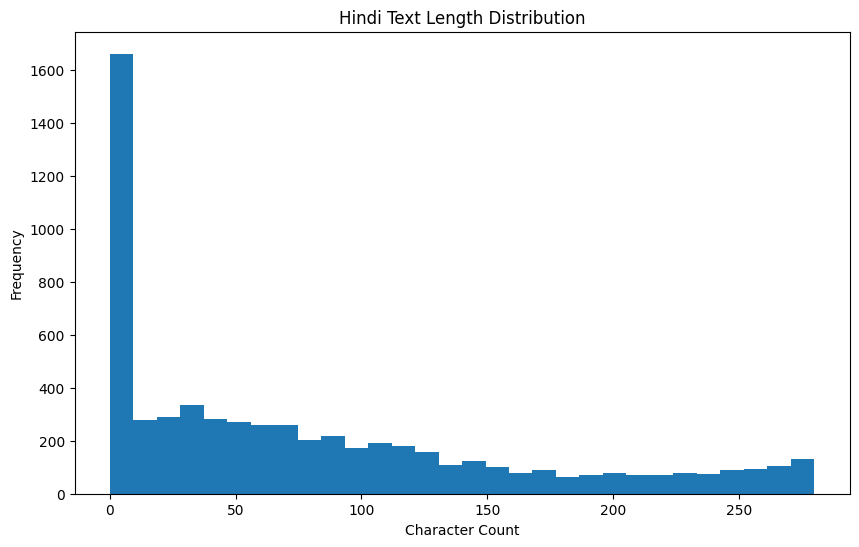

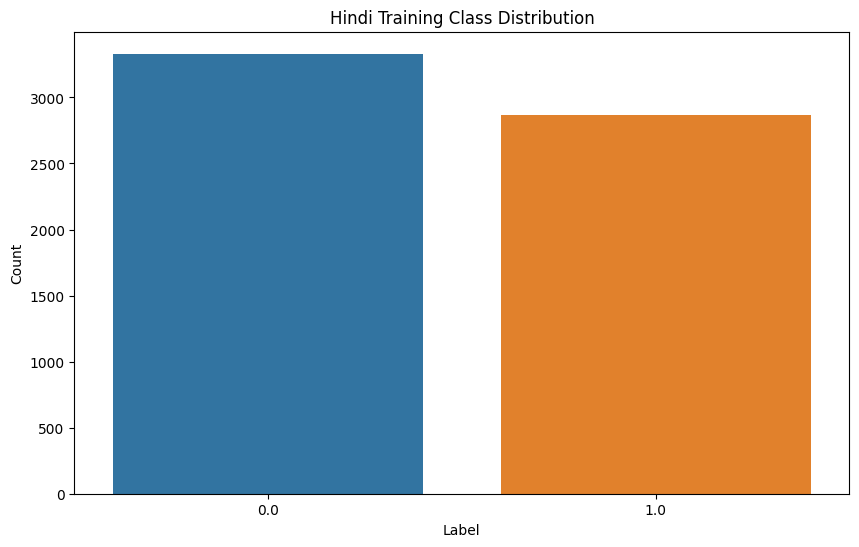

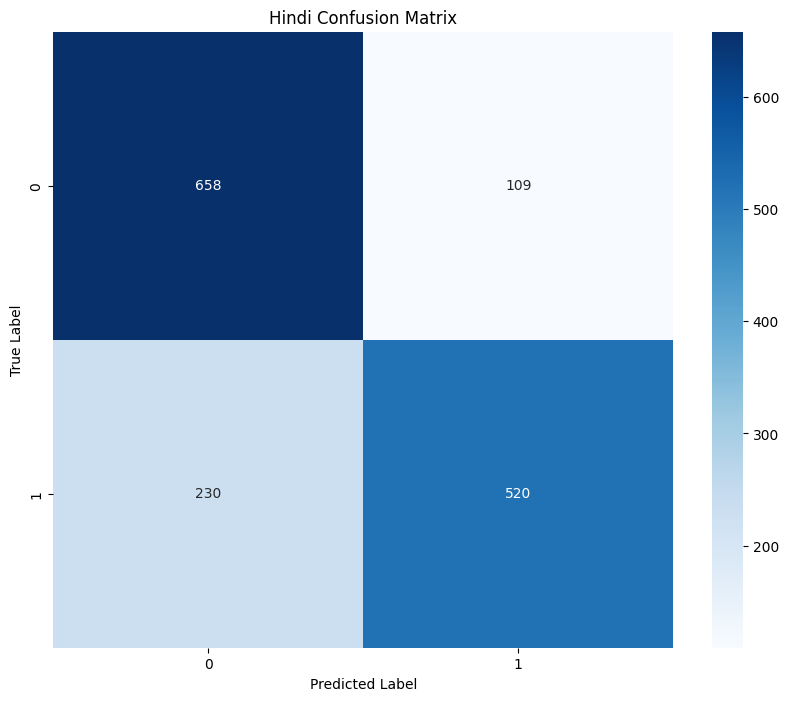

In [8]:
import pandas as pd
import numpy as np
import re
import csv
import os
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import torch
from sentence_transformers import SentenceTransformer

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Function to preprocess Hindi text
def preprocess_hindi_text(text):
    if not isinstance(text, str):
        return ""
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Handle Hindi-specific cleaning (preserve Hindi characters)
    # Hindi Unicode range: \u0900-\u097F
    # Keep Hindi characters, numerals, spaces, and remove others
    text = re.sub(r'[^\u0900-\u097F0-9\s]', '', text)
    
    # Simple tokenization approach for Hindi using whitespace
    text = ' '.join(text.split())
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Safe function to read CSV files with various error handling techniques
def safe_read_csv(file_path):
    """
    Attempts multiple strategies to safely read potentially problematic CSV files.
    
    Args:
        file_path: Path to the CSV file
    
    Returns:
        Pandas DataFrame or None if all strategies fail
    """
    # List of strategies to try
    strategies = [
        # Strategy 1: Default with minimal quoting
        {"quoting": csv.QUOTE_MINIMAL},
        
        # Strategy 2: Use Python engine instead of C engine
        {"engine": "python", "quoting": csv.QUOTE_MINIMAL},
        
        # Strategy 3: Disable quoting 
        {"quoting": csv.QUOTE_NONE, "engine": "python"},
        
        # Strategy 4: Increase field size limit
        {"quoting": csv.QUOTE_MINIMAL, "engine": "python", "on_bad_lines": "skip"},
        
        # Strategy 5: Try with different encoding
        {"encoding": "utf-8", "engine": "python"},
        
        # Strategy 6: Try with latin-1 encoding
        {"encoding": "latin-1", "engine": "python"},
        
        # Strategy 7: Try with explicit delimiter
        {"delimiter": ",", "engine": "python", "on_bad_lines": "skip"},
        
        # Strategy 8: Try with flexible error handling
        {"engine": "python", "on_bad_lines": "warn"},
    ]
    
    # Increase CSV field size limit
    import sys
    max_int = sys.maxsize
    while True:
        try:
            csv.field_size_limit(max_int)
            break
        except OverflowError:
            max_int = int(max_int/10)
    
    # Try each strategy
    for i, params in enumerate(strategies):
        try:
            print(f"Attempting CSV read strategy {i+1}...")
            df = pd.read_csv(file_path, **params)
            print(f"Strategy {i+1} successful: {params}")
            return df
        except Exception as e:
            print(f"Strategy {i+1} failed: {str(e)}")
    
    # If all strategies fail, try a more radical approach: read line by line
    try:
        print("Attempting to read CSV line by line...")
        rows = []
        with open(file_path, 'r', newline='', encoding='utf-8') as file:
            csv_reader = csv.reader(file)
            headers = next(csv_reader)
            for row in csv_reader:
                if len(row) == len(headers):  # Only include rows with correct number of fields
                    rows.append(row)
        
        df = pd.DataFrame(rows, columns=headers)
        print("Line-by-line reading successful")
        return df
    except Exception as e:
        print(f"Line-by-line reading failed: {str(e)}")
    
    # If all approaches fail
    print("All CSV reading strategies failed.")
    return None

# Initialize Sentence Transformer model
# Initialize Sentence Transformer model
print("Loading Sentence Transformer model...")
sentence_model = SentenceTransformer('google/muril-base-cased', device=device)
print(f"Sentence Transformer model loaded successfully")
# Custom transformer for Sentence Transformer embeddings
class SentenceTransformerFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, model=None, batch_size=32):
        """
        Extract Sentence Transformer embeddings for text classification.
        
        Args:
            model: Pre-trained Sentence Transformer model
            batch_size: Batch size for processing
        """
        self.model = model
        self.batch_size = batch_size
    
    def fit(self, X, y=None):
        # Nothing to fit, just initialize
        if self.model is None:
            self.model = sentence_model
        return self
    
    def transform(self, X):
        """Transform texts to sentence embeddings"""
        # Use sentence-transformers' built-in batching
        embeddings = self.model.encode(
            X.tolist(), 
            batch_size=self.batch_size, 
            show_progress_bar=True,
            convert_to_numpy=True
        )
        return embeddings

# Hindi-specific majority vote function
def majority_vote_hindi(row):
    # Extract annotation columns for Hindi dataset
    annotation_cols = ['hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5', 'hi_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_hindi_classifier(train_file, test_file=None):
    """
    Train a Hindi text classifier using SVM with combined Sentence Transformer
    and optimized Hindi text features.
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file with robust parsing
        print(f"Reading training data from {train_file}...")
        train_df = safe_read_csv(train_file)
        
        if train_df is None:
            print("Failed to read training data. Aborting.")
            return None, None, None
        
        # Check required columns
        required_cols = ['text']
        missing_cols = [col for col in required_cols if col not in train_df.columns]
        if missing_cols:
            print(f"Error: Missing required columns: {missing_cols}")
            print(f"Available columns: {train_df.columns.tolist()}")
            return None, None, None
        
        print(f"Training data loaded successfully with {len(train_df)} rows")
        
        # Preprocess text column
        print("Preprocessing Hindi training text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_hindi_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote_hindi, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the class distribution
        print("\nTraining class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Hindi Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('hindi_training_class_distribution.png')
        print("Class distribution plot saved as 'hindi_training_class_distribution.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        # Create pipeline with combined feature extractors optimized for Hindi
        print("\nCreating feature pipeline with Sentence Transformer embeddings, Hindi-optimized features, and SVM classifier...")
        
        # Feature union pipeline combining Sentence Transformers and optimized Hindi features
        feature_union = FeatureUnion([
            ('sentence_embeddings', Pipeline([
                ('sentence_transformer', SentenceTransformerFeatures(
                    model=sentence_model,
                    batch_size=32
                )),
                ('scaler_sbert', StandardScaler())
            ])),
            ('hindi_features', Pipeline([
                ('vectorizer', CountVectorizer(
                    max_features=15000,     # More features for Hindi's morphological complexity
                    ngram_range=(1, 3),     # Unigrams, bigrams and trigrams for Hindi
                    min_df=3,
                    max_df=0.9,
                    analyzer='char_wb',     # Character n-grams with word boundaries, better for Hindi
                )),
                ('tfidf', TfidfTransformer())
            ]))
        ])
        
        # Full pipeline with combined features and SVM
        pipeline = Pipeline([
            ('features', feature_union),
            ('classifier', SVC(
                C=5.0,                  # Less regularization for Hindi's feature richness 
                kernel='rbf',           # Radial basis function kernel
                gamma='scale',          # Scale gamma based on feature variance
                class_weight='balanced', # Handle class imbalance
                probability=True,       # Enable probability estimates
                random_state=42
            ))
        ])
        
        # Train the model
        print("Training the model (extracting combined features and fitting SVM)...")
        pipeline.fit(X_train, y_train)
        print("Model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            print(f"\nReading test data from {test_file}...")
            test_df = safe_read_csv(test_file)
            
            if test_df is None:
                print("Failed to read test data. Skipping evaluation.")
                return pipeline, None, None
            
            # Check required columns in test data
            missing_cols = [col for col in required_cols if col not in test_df.columns]
            if missing_cols:
                print(f"Error: Missing required columns in test data: {missing_cols}")
                print(f"Available columns: {test_df.columns.tolist()}")
                return pipeline, None, None
                
            print(f"Test data loaded successfully with {len(test_df)} rows")
            
            # Preprocess test text
            print("Preprocessing Hindi test text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_hindi_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote_hindi, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Hindi Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('hindi_confusion_matrix.png')
            print("Confusion matrix saved as 'hindi_confusion_matrix.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('hindi_test_predictions.csv', index=False)
            print("Test predictions saved to 'hindi_test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new Hindi data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = safe_read_csv(input_file)
        
        if df is None:
            print("Failed to read input data. Aborting.")
            return None
            
        # Check if 'text' column exists
        if 'text' not in df.columns:
            print(f"Error: 'text' column not found in input file.")
            print(f"Available columns: {df.columns.tolist()}")
            return None
        
        # Preprocess text column
        print("Preprocessing Hindi text...")
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get probability estimates
        probabilities = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence
        df['prediction_confidence'] = np.max(probabilities, axis=1)
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Add function to get cleaned Hindi text statistics
def analyze_hindi_dataset(file_path):
    """
    Analyze Hindi dataset characteristics after preprocessing
    
    Args:
        file_path: Path to the CSV file
    """
    try:
        # Read the CSV file
        df = safe_read_csv(file_path)
        
        if df is None:
            print("Failed to read data for analysis. Aborting.")
            return None
            
        # Check if 'text' column exists
        if 'text' not in df.columns:
            print(f"Error: 'text' column not found for analysis.")
            print(f"Available columns: {df.columns.tolist()}")
            return None
        
        # Preprocess text
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Get statistics
        text_lengths = df['processed_text'].str.len()
        word_counts = df['processed_text'].str.split().str.len()
        
        print(f"Dataset statistics for {file_path}:")
        print(f"Total samples: {len(df)}")
        print(f"Average text length (characters): {text_lengths.mean():.2f}")
        print(f"Average word count: {word_counts.mean():.2f}")
        print(f"Max text length: {text_lengths.max()}")
        print(f"Min text length: {text_lengths.min()}")
        
        # Plot text length distribution
        plt.figure(figsize=(10, 6))
        plt.hist(text_lengths, bins=30)
        plt.title('Hindi Text Length Distribution')
        plt.xlabel('Character Count')
        plt.ylabel('Frequency')
        plt.savefig('hindi_text_length_distribution.png')
        print("Text length distribution saved as 'hindi_text_length_distribution.png'")
        
        return df
    
    except Exception as e:
        print(f"Error: {e}")
        return None

# Add these imports at the top of your script
import joblib
import pickle

# Function to save the trained model
def save_model(model, file_path="hindi_classifier_model.joblib"):
    """
    Save the trained model to disk
    
    Args:
        model: Trained classifier model
        file_path: Path where to save the model
    """
    try:
        print(f"Saving model to {file_path}...")
        joblib.dump(model, file_path)
        print(f"Model saved successfully to {file_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

# Function to load the saved model
def load_model(file_path="hindi_classifier_model.joblib"):
    """
    Load a saved model from disk
    
    Args:
        file_path: Path to the saved model
        
    Returns:
        Loaded model or None if loading fails
    """
    try:
        print(f"Loading model from {file_path}...")
        model = joblib.load(file_path)
        print("Model loaded successfully")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Function to perform inference on a single text input
def predict_text(model, text):
    """
    Make a prediction on a single Hindi text input
    
    Args:
        model: Trained classifier model
        text: Text string to classify
        
    Returns:
        Dictionary with prediction results
    """
    try:
        # Preprocess the text
        processed_text = preprocess_hindi_text(text)
        
        # Make prediction
        prediction_class = model.predict([processed_text])[0]
        
        # Get probability estimates
        probabilities = model.predict_proba([processed_text])[0]
        confidence = max(probabilities)
        
        # Convert string prediction back to float value
        prediction_value = float(prediction_class)
        
        result = {
            'original_text': text,
            'processed_text': processed_text,
            'predicted_label_class': prediction_class,
            'predicted_label_value': prediction_value,
            'confidence': confidence
        }
        
        return result
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

# Function to test the model on sample texts
def test_sample_texts(model, samples=None):
    """
    Test the model on a set of sample Hindi texts
    
    Args:
        model: Trained classifier model
        samples: List of texts to test (if None, uses default samples)
        
    Returns:
        DataFrame with prediction results
    """
    if samples is None:
        # Default sample texts - replace with actual Hindi text samples
        samples = [
            "मैं आज बहुत खुश हूँ",  # I am very happy today
            "यह फिल्म बहुत बुरी थी",  # This movie was very bad
            "उसने मुझे धोखा दिया",  # He cheated me
            "हम सभी के लिए एक अच्छा दिन है",  # It's a good day for all of us
            "इस खाने का स्वाद बहुत अच्छा है"  # This food tastes very good
        ]
    
    results = []
    for text in samples:
        result = predict_text(model, text)
        if result:
            results.append(result)
    
    # Create DataFrame from results
    if results:
        df = pd.DataFrame(results)
        print("\nSample prediction results:")
        print(df[['original_text', 'predicted_label_value', 'confidence']])
        return df
    else:
        print("No valid predictions were made.")
        return None


# Add this at the end of your main block
if __name__ == "__main__":
    train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_hi_l3.csv"  # Hindi training file
    test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_hi_l3.csv"     # Hindi test file
    
    # Optional: Analyze dataset characteristics
    print("\n=== Analyzing Hindi dataset ===")
    analyze_hindi_dataset(train_file)
    
    # Train the model and evaluate on test data
    model, macro_f1, report = train_hindi_classifier(train_file, test_file)
    
    # Save the trained model
    if model is not None:
        save_model(model, "hindi_classifier_model_3.joblib")
        
        # Test the model on sample texts
        print("\n=== Testing model on sample texts ===")
        test_sample_texts(model)
        
        # Example of loading the saved model and using it
        print("\n=== Loading saved model and performing inference ===")
        loaded_model = load_model("hindi_classifier_model_l3.joblib")
        if loaded_model is not None:
            # Create your own sample text list for testing
            my_samples = [
                "मुझे यह पुस्तक पसंद आई",  # I liked this book
                "राजनीति पर चर्चा करना मुश्किल है",  # Discussing politics is difficult
                "क्या आपने आज का समाचार देखा?"  # Did you see today's news?
            ]
            test_sample_texts(loaded_model, my_samples)
        
        # For completeness, show how to use the model on new data
        print("\n=== Using model on new data ===")
        new_data_file = test_file  # Using test file as an example
        output_file = "hindi_new_predictions.csv"
        predict_on_new_data(model, new_data_file, output_file)

In [9]:
import pandas as pd
import numpy as np
import re
import csv
import os
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import torch
from sentence_transformers import SentenceTransformer

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Function to preprocess Hindi text
def preprocess_hindi_text(text):
    if not isinstance(text, str):
        return ""
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Handle Hindi-specific cleaning (preserve Hindi characters)
    # Hindi Unicode range: \u0900-\u097F
    # Keep Hindi characters, numerals, spaces, and remove others
    text = re.sub(r'[^\u0900-\u097F0-9\s]', '', text)
    
    # Simple tokenization approach for Hindi using whitespace
    text = ' '.join(text.split())
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Safe function to read CSV files with various error handling techniques
def safe_read_csv(file_path):
    """
    Attempts multiple strategies to safely read potentially problematic CSV files.
    
    Args:
        file_path: Path to the CSV file
    
    Returns:
        Pandas DataFrame or None if all strategies fail
    """
    # List of strategies to try
    strategies = [
        # Strategy 1: Default with minimal quoting
        {"quoting": csv.QUOTE_MINIMAL},
        
        # Strategy 2: Use Python engine instead of C engine
        {"engine": "python", "quoting": csv.QUOTE_MINIMAL},
        
        # Strategy 3: Disable quoting 
        {"quoting": csv.QUOTE_NONE, "engine": "python"},
        
        # Strategy 4: Increase field size limit
        {"quoting": csv.QUOTE_MINIMAL, "engine": "python", "on_bad_lines": "skip"},
        
        # Strategy 5: Try with different encoding
        {"encoding": "utf-8", "engine": "python"},
        
        # Strategy 6: Try with latin-1 encoding
        {"encoding": "latin-1", "engine": "python"},
        
        # Strategy 7: Try with explicit delimiter
        {"delimiter": ",", "engine": "python", "on_bad_lines": "skip"},
        
        # Strategy 8: Try with flexible error handling
        {"engine": "python", "on_bad_lines": "warn"},
    ]
    
    # Increase CSV field size limit
    import sys
    max_int = sys.maxsize
    while True:
        try:
            csv.field_size_limit(max_int)
            break
        except OverflowError:
            max_int = int(max_int/10)
    
    # Try each strategy
    for i, params in enumerate(strategies):
        try:
            print(f"Attempting CSV read strategy {i+1}...")
            df = pd.read_csv(file_path, **params)
            print(f"Strategy {i+1} successful: {params}")
            return df
        except Exception as e:
            print(f"Strategy {i+1} failed: {str(e)}")
    
    # If all strategies fail, try a more radical approach: read line by line
    try:
        print("Attempting to read CSV line by line...")
        rows = []
        with open(file_path, 'r', newline='', encoding='utf-8') as file:
            csv_reader = csv.reader(file)
            headers = next(csv_reader)
            for row in csv_reader:
                if len(row) == len(headers):  # Only include rows with correct number of fields
                    rows.append(row)
        
        df = pd.DataFrame(rows, columns=headers)
        print("Line-by-line reading successful")
        return df
    except Exception as e:
        print(f"Line-by-line reading failed: {str(e)}")
    
    # If all approaches fail
    print("All CSV reading strategies failed.")
    return None

# Initialize Sentence Transformer model
# Initialize Sentence Transformer model
print("Loading Sentence Transformer model...")
sentence_model = SentenceTransformer('google/muril-base-cased', device=device)
print(f"Sentence Transformer model loaded successfully")
# Custom transformer for Sentence Transformer embeddings
class SentenceTransformerFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, model=None, batch_size=32):
        """
        Extract Sentence Transformer embeddings for text classification.
        
        Args:
            model: Pre-trained Sentence Transformer model
            batch_size: Batch size for processing
        """
        self.model = model
        self.batch_size = batch_size
    
    def fit(self, X, y=None):
        # Nothing to fit, just initialize
        if self.model is None:
            self.model = sentence_model
        return self
    
    def transform(self, X):
        """Transform texts to sentence embeddings"""
        # Use sentence-transformers' built-in batching
        embeddings = self.model.encode(
            X.tolist(), 
            batch_size=self.batch_size, 
            show_progress_bar=True,
            convert_to_numpy=True
        )
        return embeddings

# Hindi-specific majority vote function
def majority_vote_hindi(row):
    # Extract annotation columns for Hindi dataset
    annotation_cols = ['hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5', 'hi_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

# Add this function to your first code
def train_combined_hindi_classifier(l1_file, l3_file, test_l1_file=None, test_l3_file=None):
    """
    Combine L1 and L3 datasets, train a model, and evaluate.
    Final label is 1 if both L1 and L3 are 1, otherwise 0.
    
    Args:
        l1_file: Path to the L1 CSV file
        l3_file: Path to the L3 CSV file
        test_l1_file: Path to the L1 test CSV file (optional)
        test_l3_file: Path to the L3 test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the L1 CSV file
        print(f"Reading L1 data from {l1_file}...")
        l1_df = safe_read_csv(l1_file)
        
        # Read the L3 CSV file
        print(f"Reading L3 data from {l3_file}...")
        l3_df = safe_read_csv(l3_file)
        
        if l1_df is None or l3_df is None:
            print("Failed to read L1 or L3 data. Aborting.")
            return None, None, None
        
        # Ensure both datasets have a unique ID to match sentences
        if 'id' not in l1_df.columns:
            l1_df['id'] = range(len(l1_df))
        if 'id' not in l3_df.columns:
            l3_df['id'] = range(len(l3_df))
        
        # Calculate majority vote for L1 dataset
        print("Calculating majority vote for L1 labels...")
        l1_df['l1_label'] = l1_df.apply(majority_vote_hindi, axis=1)  # Using the existing majority_vote function
        
        # Calculate majority vote for L3 dataset
        print("Calculating majority vote for L3 labels...")
        l3_df['l3_label'] = l3_df.apply(majority_vote_hindi, axis=1)
        
        # Extract essential columns from each dataset
        l1_subset = l1_df[['id', 'text', 'l1_label']]
        l3_subset = l3_df[['id', 'l3_label']]
        
        # Merge datasets on ID
        print("Merging L1 and L3 datasets...")
        merged_df = pd.merge(l1_subset, l3_subset, on='id', how='inner')
        
        # Determine final label: 1 if both L1 and L3 are 1, otherwise 0
        merged_df['final_label'] = ((merged_df['l1_label'] == 1.0) & 
                                   (merged_df['l3_label'] == 1.0)).astype(int)
        
        # Preprocess text column with Hindi-specific preprocessing
        print("Preprocessing Hindi text...")
        merged_df['processed_text'] = merged_df['text'].apply(preprocess_hindi_text)
        
        # Print the class distribution
        print("\nFinal label class distribution:")
        class_dist = merged_df['final_label'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='final_label', data=merged_df)
        plt.title('Combined Dataset Class Distribution')
        plt.xlabel('Final Label (1 if both L1 and L3 are 1, otherwise 0)')
        plt.ylabel('Count')
        plt.savefig('combined_class_distribution.png')
        print("Class distribution plot saved as 'combined_class_distribution.png'")
        
        # Prepare training data
        X_train = merged_df['processed_text']
        y_train = merged_df['final_label']  # Using the combined label
        
        # Create feature pipeline with Sentence Transformer embeddings and Bag of Words
        print("\nCreating feature pipeline with Sentence Transformer embeddings, Bag of Words, and SVM classifier...")
        
        feature_union = FeatureUnion([
            ('sentence_embeddings', Pipeline([
                ('sentence_transformer', SentenceTransformerFeatures(
                    model=sentence_model,
                    batch_size=32
                )),
                ('scaler_sbert', StandardScaler())
            ])),
            ('hindi_features', Pipeline([
                ('vectorizer', CountVectorizer(
                    max_features=15000,     # More features for Hindi's morphological complexity
                    ngram_range=(1, 3),     # Unigrams, bigrams and trigrams for Hindi
                    min_df=3,
                    max_df=0.9,
                    analyzer='char_wb',     # Character n-grams with word boundaries, better for Hindi
                )),
                ('tfidf', TfidfTransformer())
            ]))
        ])
        
        # Full pipeline with combined features and SVM
        pipeline = Pipeline([
            ('features', feature_union),
            ('classifier', SVC(
                C=5.0,                  # Less regularization for Hindi's feature richness 
                kernel='rbf',           # Radial basis function kernel
                gamma='scale',          # Scale gamma based on feature variance
                class_weight='balanced', # Handle class imbalance
                probability=True,       # Enable probability estimates
                random_state=42
            ))
        ])
        
        # Train the model
        print("Training the model on combined L1 and L3 data...")
        pipeline.fit(X_train, y_train)
        print("Model training complete!")
        
        # If test files are provided, evaluate on combined test data
        if test_l1_file and test_l3_file:
            # Read the L1 test CSV file
            print(f"\nReading L1 test data from {test_l1_file}...")
            l1_test_df = safe_read_csv(test_l1_file)
            
            # Read the L3 test CSV file
            print(f"Reading L3 test data from {test_l3_file}...")
            l3_test_df = safe_read_csv(test_l3_file)
            
            if l1_test_df is None or l3_test_df is None:
                print("Failed to read L1 or L3 test data. Skipping evaluation.")
                return pipeline, None, None
            
            # Ensure both test datasets have a unique ID
            if 'id' not in l1_test_df.columns:
                l1_test_df['id'] = range(len(l1_test_df))
            if 'id' not in l3_test_df.columns:
                l3_test_df['id'] = range(len(l3_test_df))
            
            # Calculate majority vote for test datasets
            l1_test_df['l1_label'] = l1_test_df.apply(majority_vote_hindi, axis=1)
            l3_test_df['l3_label'] = l3_test_df.apply(majority_vote_hindi, axis=1)
            
            # Extract essential columns from test datasets
            l1_test_subset = l1_test_df[['id', 'text', 'l1_label']]
            l3_test_subset = l3_test_df[['id', 'l3_label']]
            
            # Merge test datasets
            print("Merging L1 and L3 test datasets...")
            merged_test_df = pd.merge(l1_test_subset, l3_test_subset, on='id', how='inner')
            
            # Determine final test label
            merged_test_df['final_label'] = ((merged_test_df['l1_label'] == 1.0) & 
                                           (merged_test_df['l3_label'] == 1.0)).astype(int)
            
            # Preprocess test text
            merged_test_df['processed_text'] = merged_test_df['text'].apply(preprocess_hindi_text)
            
            # Prepare test data
            X_test = merged_test_df['processed_text']
            y_test = merged_test_df['final_label']
            
            # Make predictions
            print("Making predictions on combined test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Combined Test Data Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('combined_test_confusion_matrix.png')
            print("Confusion matrix saved as 'combined_test_confusion_matrix.png'")
            
            # Save sample predictions
            results_df = pd.DataFrame({
                'id': merged_test_df['id'],
                'text': X_test.values,
                'l1_label': merged_test_df['l1_label'],
                'l3_label': merged_test_df['l3_label'],
                'true_combined_label': y_test.values,
                'predicted_label': y_pred,
                'prediction_confidence': np.max(pipeline.predict_proba(X_test), axis=1)
            })
            results_df.to_csv('combined_test_predictions.csv', index=False)
            print("Test predictions saved to 'combined_test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test files provided. Model trained successfully on combined data.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new Hindi data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = safe_read_csv(input_file)
        
        if df is None:
            print("Failed to read input data. Aborting.")
            return None
            
        # Check if 'text' column exists
        if 'text' not in df.columns:
            print(f"Error: 'text' column not found in input file.")
            print(f"Available columns: {df.columns.tolist()}")
            return None
        
        # Preprocess text column
        print("Preprocessing Hindi text...")
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get probability estimates
        probabilities = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence
        df['prediction_confidence'] = np.max(probabilities, axis=1)
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Add function to get cleaned Hindi text statistics
def analyze_hindi_dataset(file_path):
    """
    Analyze Hindi dataset characteristics after preprocessing
    
    Args:
        file_path: Path to the CSV file
    """
    try:
        # Read the CSV file
        df = safe_read_csv(file_path)
        
        if df is None:
            print("Failed to read data for analysis. Aborting.")
            return None
            
        # Check if 'text' column exists
        if 'text' not in df.columns:
            print(f"Error: 'text' column not found for analysis.")
            print(f"Available columns: {df.columns.tolist()}")
            return None
        
        # Preprocess text
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Get statistics
        text_lengths = df['processed_text'].str.len()
        word_counts = df['processed_text'].str.split().str.len()
        
        print(f"Dataset statistics for {file_path}:")
        print(f"Total samples: {len(df)}")
        print(f"Average text length (characters): {text_lengths.mean():.2f}")
        print(f"Average word count: {word_counts.mean():.2f}")
        print(f"Max text length: {text_lengths.max()}")
        print(f"Min text length: {text_lengths.min()}")
        
        # Plot text length distribution
        plt.figure(figsize=(10, 6))
        plt.hist(text_lengths, bins=30)
        plt.title('Hindi Text Length Distribution')
        plt.xlabel('Character Count')
        plt.ylabel('Frequency')
        plt.savefig('hindi_text_length_distribution.png')
        print("Text length distribution saved as 'hindi_text_length_distribution.png'")
        
        return df
    
    except Exception as e:
        print(f"Error: {e}")
        return None

# Add these imports at the top of your script
import joblib
import pickle

# Function to save the trained model
def save_model(model, file_path="hindi_classifier_model.joblib"):
    """
    Save the trained model to disk
    
    Args:
        model: Trained classifier model
        file_path: Path where to save the model
    """
    try:
        print(f"Saving model to {file_path}...")
        joblib.dump(model, file_path)
        print(f"Model saved successfully to {file_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

# Function to load the saved model
def load_model(file_path="hindi_classifier_model.joblib"):
    """
    Load a saved model from disk
    
    Args:
        file_path: Path to the saved model
        
    Returns:
        Loaded model or None if loading fails
    """
    try:
        print(f"Loading model from {file_path}...")
        model = joblib.load(file_path)
        print("Model loaded successfully")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Function to perform inference on a single text input
def predict_text(model, text):
    """
    Make a prediction on a single Hindi text input
    
    Args:
        model: Trained classifier model
        text: Text string to classify
        
    Returns:
        Dictionary with prediction results
    """
    try:
        # Preprocess the text
        processed_text = preprocess_hindi_text(text)
        
        # Make prediction
        prediction_class = model.predict([processed_text])[0]
        
        # Get probability estimates
        probabilities = model.predict_proba([processed_text])[0]
        confidence = max(probabilities)
        
        # Convert string prediction back to float value
        prediction_value = float(prediction_class)
        
        result = {
            'original_text': text,
            'processed_text': processed_text,
            'predicted_label_class': prediction_class,
            'predicted_label_value': prediction_value,
            'confidence': confidence
        }
        
        return result
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

# Function to test the model on sample texts
def test_sample_texts(model, samples=None):
    """
    Test the model on a set of sample Hindi texts
    
    Args:
        model: Trained classifier model
        samples: List of texts to test (if None, uses default samples)
        
    Returns:
        DataFrame with prediction results
    """
    if samples is None:
        # Default sample texts - replace with actual Hindi text samples
        samples = [
            "मैं आज बहुत खुश हूँ",  # I am very happy today
            "यह फिल्म बहुत बुरी थी",  # This movie was very bad
            "उसने मुझे धोखा दिया",  # He cheated me
            "हम सभी के लिए एक अच्छा दिन है",  # It's a good day for all of us
            "इस खाने का स्वाद बहुत अच्छा है"  # This food tastes very good
        ]
    
    results = []
    for text in samples:
        result = predict_text(model, text)
        if result:
            results.append(result)
    
    # Create DataFrame from results
    if results:
        df = pd.DataFrame(results)
        print("\nSample prediction results:")
        print(df[['original_text', 'predicted_label_value', 'confidence']])
        return df
    else:
        print("No valid predictions were made.")
        return None

# Add this function to your first code for inference on combined model
def predict_combined_single_text(model, text):
    """
    Use a trained combined model to make prediction on a single Hindi text
    
    Args:
        model: Trained classifier pipeline for combined L1 and L3 data
        text: Hindi text string
        
    Returns:
        Dictionary with prediction results
    """
    try:
        # Preprocess the text
        processed_text = preprocess_hindi_text(text)
        
        # Make prediction
        prediction = model.predict([processed_text])[0]
        
        # Get probability estimates
        probabilities = model.predict_proba([processed_text])[0]
        confidence = max(probabilities)
        
        # Interpret the combined prediction
        if prediction == 1:
            interpretation = "Potentially problematic content detected (both L1 and L3 issues)"
        else:
            interpretation = "No significant combined issues detected"
        
        result = {
            'original_text': text,
            'processed_text': processed_text,
            'prediction': prediction,
            'confidence': confidence,
            'interpretation': interpretation
        }
        
        print("\nPrediction Results:")
        print(f"Original Text: {text}")
        print(f"Processed Text: {processed_text}")
        print(f"Combined Prediction: {prediction} ({interpretation})")
        print(f"Confidence: {confidence:.4f}")
        
        return result
        
    except Exception as e:
        print(f"Error during prediction: {e}")
        import traceback
        traceback.print_exc()
        return None


Using device: cuda
Loading Sentence Transformer model...
Sentence Transformer model loaded successfully


Reading L1 data from /kaggle/input/capstone/uli_dataset-main/training/train_hi_l1.csv...
Attempting CSV read strategy 1...
Strategy 1 successful: {'quoting': 0}
Reading L3 data from /kaggle/input/capstone/uli_dataset-main/training/train_hi_l3.csv...
Attempting CSV read strategy 1...
Strategy 1 successful: {'quoting': 0}
Calculating majority vote for L1 labels...
Calculating majority vote for L3 labels...
Merging L1 and L3 datasets...
Preprocessing Hindi text...

Final label class distribution:
final_label
0    4875
1    1322
Name: count, dtype: int64
Class distribution plot saved as 'combined_class_distribution.png'

Creating feature pipeline with Sentence Transformer embeddings, Bag of Words, and SVM classifier...
Training the model on combined L1 and L3 data...


Batches:   0%|          | 0/194 [00:00<?, ?it/s]

Model training complete!

Reading L1 test data from /kaggle/input/capstone/uli_dataset-main/testing/test_hi_l1.csv...
Attempting CSV read strategy 1...
Strategy 1 failed: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.

Attempting CSV read strategy 2...
Strategy 2 successful: {'engine': 'python', 'quoting': 0}
Reading L3 test data from /kaggle/input/capstone/uli_dataset-main/testing/test_hi_l3.csv...
Attempting CSV read strategy 1...
Strategy 1 failed: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.

Attempting CSV read strategy 2...
Strategy 2 successful: {'engine': 'python', 'quoting': 0}
Merging L1 and L3 test datasets...
Making predictions on combined test data...


Batches:   0%|          | 0/48 [00:00<?, ?it/s]


Evaluating model performance...

Macro F1 Score: 0.6689

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1204
           1       0.60      0.36      0.45       313

    accuracy                           0.82      1517
   macro avg       0.72      0.65      0.67      1517
weighted avg       0.80      0.82      0.80      1517

Confusion matrix saved as 'combined_test_confusion_matrix.png'


Batches:   0%|          | 0/48 [00:00<?, ?it/s]

Test predictions saved to 'combined_test_predictions.csv'
Saving model to hindi_combined_l1_l3_model.joblib...
Model saved successfully to hindi_combined_l1_l3_model.joblib

=== Testing combined model on sample texts ===
Error during prediction: 'list' object has no attribute 'tolist'
Error during prediction: 'list' object has no attribute 'tolist'
Error during prediction: 'list' object has no attribute 'tolist'
Error during prediction: 'list' object has no attribute 'tolist'
Error during prediction: 'list' object has no attribute 'tolist'

=== Loading saved combined model and performing inference ===
Loading model from hindi_combined_l1_l3_model.joblib...


Traceback (most recent call last):
  File "/tmp/ipykernel_31/1673298019.py", line 672, in predict_combined_single_text
    prediction = model.predict([processed_text])[0]
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 480, in predict
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 1242, in transform
    Xs = Parallel(n_jobs=self.n_jobs)(
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/joblib/paral

Model loaded successfully
Error during prediction: 'list' object has no attribute 'tolist'
Error during prediction: 'list' object has no attribute 'tolist'
Error during prediction: 'list' object has no attribute 'tolist'


Traceback (most recent call last):
  File "/tmp/ipykernel_31/1673298019.py", line 672, in predict_combined_single_text
    prediction = model.predict([processed_text])[0]
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 480, in predict
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 1242, in transform
    Xs = Parallel(n_jobs=self.n_jobs)(
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/joblib/paral

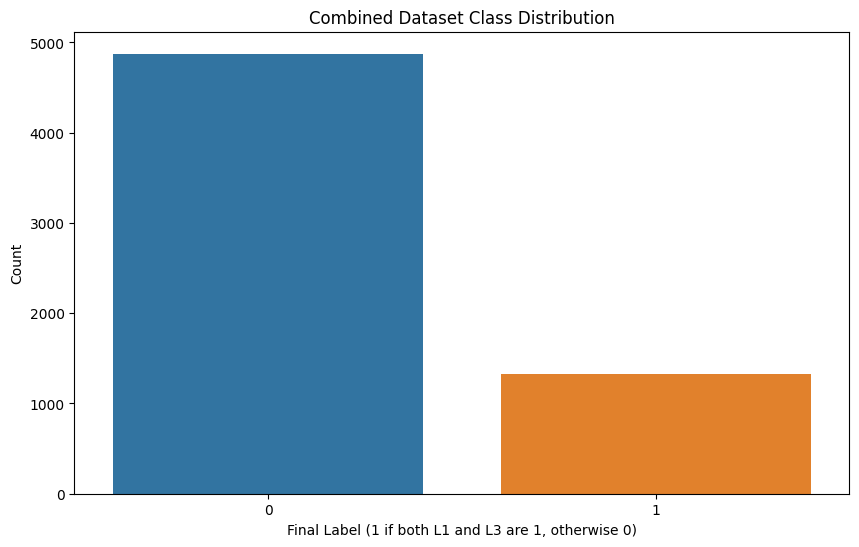

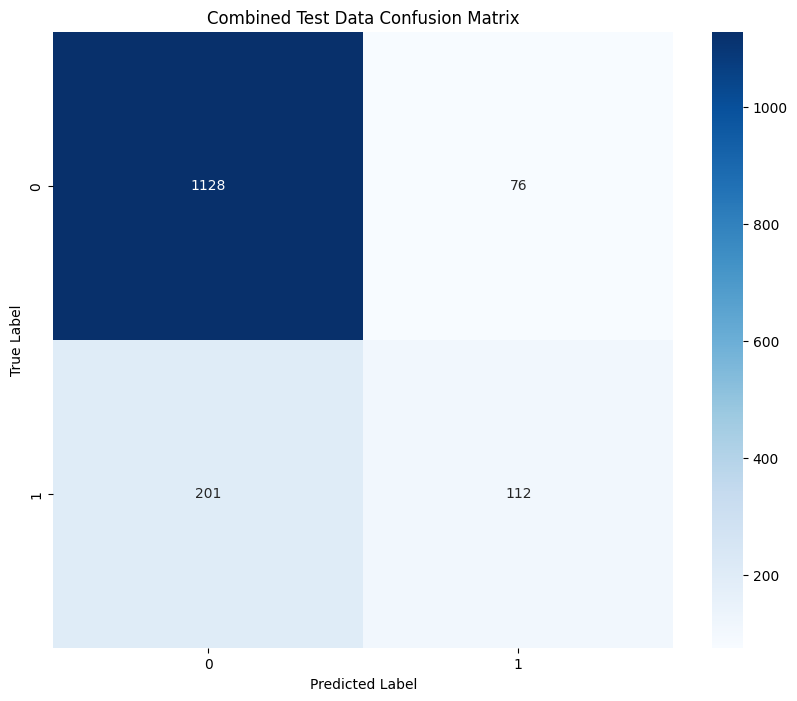

In [10]:
# Add this to your main block to use the combined model
if __name__ == "__main__":
    # Define paths to your L1 and L3 files
    train_l1_file = "/kaggle/input/capstone/uli_dataset-main/training/train_hi_l1.csv"  # Hindi L1 training file
    train_l3_file = "/kaggle/input/capstone/uli_dataset-main/training/train_hi_l3.csv"  # Hindi L3 training file
    test_l1_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_hi_l1.csv"     # Hindi L1 test file
    test_l3_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_hi_l3.csv"     # Hindi L3 test file
    
    # Train the combined model and evaluate on test data
    combined_model, macro_f1, report = train_combined_hindi_classifier(train_l1_file, train_l3_file, 
                                                                     test_l1_file, test_l3_file)
    
    # Save the trained model
    if combined_model is not None:
        save_model(combined_model, "hindi_combined_l1_l3_model.joblib")
        
        # Test the model on sample texts
        print("\n=== Testing combined model on sample texts ===")
        # Create your own sample text list for testing
        sample_texts = [
            "मैं आज बहुत खुश हूँ",  # I am very happy today
            "यह फिल्म बहुत बुरी थी",  # This movie was very bad
            "उसने मुझे धोखा दिया",  # He cheated me
            "हम सभी के लिए एक अच्छा दिन है",  # It's a good day for all of us
            "इस खाने का स्वाद बहुत अच्छा है"  # This food tastes very good
        ]
        
        # Process each sample text
        for text in sample_texts:
            predict_combined_single_text(combined_model, text)
        
        # Load the saved model and test (optional)
        print("\n=== Loading saved combined model and performing inference ===")
        loaded_model = load_model("hindi_combined_l1_l3_model.joblib")
        if loaded_model is not None:
            # Additional samples
            more_samples = [
                "मुझे यह पुस्तक पसंद आई",  # I liked this book
                "राजनीति पर चर्चा करना मुश्किल है",  # Discussing politics is difficult
                "क्या आपने आज का समाचार देखा?"  # Did you see today's news?
            ]
            
            # Process each additional sample
            for text in more_samples:
                predict_combined_single_text(loaded_model, text)